In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader 

from ccn import Constraint, ConstraintsGroup, ConstraintsLayer, train, test, draw_classes
from shapes import Rectangle, ShapeDataset

### Define the dataset

In [8]:
rect0 = Rectangle(0.1, 0.6, 0.1, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)
combined = rect0 | rect1
shapes = [rect0, combined]

points = 10000
train_data = ShapeDataset(shapes, points)
test_data = ShapeDataset(shapes, points // 10)

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

### Define the neural network

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### Train and test the model

In [17]:
clayer = ConstraintsLayer(ConstraintsGroup([Constraint('1 :- 0')]), 2)
loss_fn = nn.BCELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999))

In [20]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, clayer, loss_fn, optimizer)
    test(test_dataloader, model, clayer, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.193637 [    0/10000]
loss: 0.143477 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003643 

Epoch 2
-------------------------------
loss: 0.193594 [    0/10000]
loss: 0.143367 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003642 

Epoch 3
-------------------------------
loss: 0.193550 [    0/10000]
loss: 0.143254 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003642 

Epoch 4
-------------------------------
loss: 0.193505 [    0/10000]
loss: 0.143147 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003641 

Epoch 5
-------------------------------
loss: 0.193426 [    0/10000]
loss: 0.143028 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003641 

Epoch 6
-------------------------------
loss: 0.193386 [    0/10000]
loss: 0.142901 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 82.8%
 Avg loss: 0.003641 

Epoch 7
-------------------------------
loss: 0.193344 [  

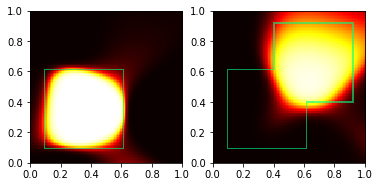

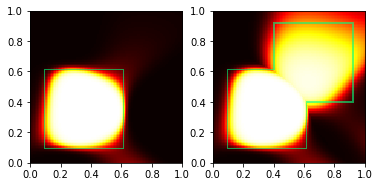

In [21]:
draw_classes(model, draw=(lambda ax, i: shapes[i].plot(ax)))
draw_classes(lambda x: clayer(model(x)), draw=(lambda ax, i: shapes[i].plot(ax)))